In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

!pip install deepface

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import statistics
import warnings

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import statistics
from sklearn.manifold import TSNE

import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


from deepface import DeepFace
from operator import itemgetter
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r1, r0927846, r3, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [2]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [3]:
# The training set contains an identifier, name, image information and class label
train.head(1)

,name,class,img
id,,,
0,Mila_Kunis,2,"[[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4..."


In [4]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

,img
id,
0,"[[[209, 210, 205], [208, 209, 204], [208, 209,..."


In [5]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

,img,class
name,,
Jesse_Eisenberg,30,1
Michael_Cera,10,0
Mila_Kunis,30,2
Sarah_Hyland,10,0


Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [184]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

In [4]:
class DeepFacePreprocessor():
    """Preprocessing pipeline built around DeepFace face detector. """
    
    def __init__(self, backend, face_size):
        self.face_size = face_size
        self.backend = backend
            
    def detect_faces(self, img, backend):
        """Detect all faces in an image."""
        return DeepFace.extract_faces(img, detector_backend = backend, enforce_detection=False, align=False, target_size=self.face_size)
        
    def extract_faces(self, img):
        """Returns 3 most probable faces (cropped) in an image."""
        
        faces = self.detect_faces(img, self.backend)
        faces.sort(key=itemgetter('confidence'), reverse=True)
        # If no faces found, try again with a better backend
        if faces[0]['confidence'] == 0:
            faces = self.detect_faces(img, "retinaface")

        # If still no faces found, return empty list
        if faces[0]['confidence'] == 0:
            return []
        
        #select 3 best matches
        faces = faces[:3]
        #normalize faces
        faces_normalized = [cv2.normalize(face['face'], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8) for face in faces]
        return [cv2.cvtColor(face, cv2.COLOR_BGR2RGB) for face in faces_normalized]
    
    def preprocess(self, data_row, i, manual_choices=None):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        elif len(faces) != 1 and manual_choices is not None and i in manual_choices:
            #if we detect more than 1 face we can select correct one manually
            return faces[manual_choices[i]]
        
        # if we didn't specify a face to choose manualy return the first one
        return faces[0]
        
    def __call__(self, data, manual_choices=None):
        return np.stack([self.preprocess(row, i, manual_choices) for i, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [ ]:
# # parameter to play with 
# FACE_SIZE = (150, 150)

# def plot_image_sequence(data, n, imgs_per_row=7):
#     n_rows = 1 + int(n/(imgs_per_row+1))
#     n_cols = min(imgs_per_row, n)

#     f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
#     for i in range(n):
#         if n == 1:
#             ax.imshow(data[i])
#         elif n_rows > 1:
#             ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
#         else:
#             ax[int(i%n)].imshow(data[i])
#     plt.show()

    
# #preprocessed data 
# # preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

# # train_X, train_y = preprocessor(train), train['class'].values
# # test_X = preprocessor(test)

# # we are using DeepFacePreprocessor since it has a better performance
# # if data hasn't been preprocessed yet
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     preprocessor = DeepFacePreprocessor("ssd", FACE_SIZE)
    
#     manual_choices = {0: 0, 9: 0, 18: 1, 26: 0, 30: 0, 32: 0, 34: 2, 41: 0, 49:1, 50:0, 52:1, 53:1, 57:0, 59:1, 61:0, 70:0, 73:0, 77:0}
#     train_X, train_y = preprocessor(train, manual_choices), train['class'].values
#     test_X = preprocessor(test)
    
#     # Filtering imgs that are not faces ONCE
#     a = train_y[train_y == 2]
#     np.put(a, [24], 0)
#     train_y[train_y == 2] = a


In [ ]:
# # plot faces of Michael and Sarah

# plot_image_sequence(train_X[train_y == 0], n=len(train_X[train_y == 0]), imgs_per_row=10)

In [ ]:
# # plot faces of Jesse
# # 6, 12?, 15, 18, 27



# plot_image_sequence(train_X[train_y == 1], n=len(train_X[train_y == 1]), imgs_per_row=10)

In [ ]:
# # plot faces of Mila
# # 5?, 7?, 15, 24

# plot_image_sequence(train_X[train_y == 2], n=len(train_X[train_y == 2]), imgs_per_row=10)

In [187]:
# a = train_y[train_y == 1]
# for i in [6, 12, 15, 18, 27]:
#     np.put(a, i, 0)
# train_y[train_y == 1] = a

# a = train_y[train_y == 2]
# for i in [5, 7, 15, 23, 24]:
#     np.put(a, i, 0)
# train_y[train_y == 2] = a

Now we are ready to rock!

In [ ]:
# plot_image_sequence(val_X, n=len(val_X), imgs_per_row=10)

In [11]:
# val_X = test_X[-100:]
# val_y = [0, 0, 1, 0, 0, 1, 2, 0, 2, 0,
#          0, 0, 0, 0, 1, 1, 0, 1, 0, 2,
#          2, 0, 2, 0, 0, 1, 1, 0, 0, 1,
#          0, 0, 0, 1, 0, 2, 2, 0, 0, 2,
#          0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
#          0, 1, 0, 0, 0, 1, 0, 1, 1, 2,
#          0, 0, 0, 0, 1, 0, 2, 0, 2, 1,
#          0, 0, 2, 0, 0, 0, 2, 0, 2, 0,
#          0, 0, 0, 0, 1, 2, 2, 0, 1, 1,
#          0, 1, 0, 0, 2, 0, 0, 1, 0, 0]
# val_y = np.asarray(val_y)
# val_y = keras.utils.to_categorical(val_y, num_classes = 3)

In [47]:
# # save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)
# np.save(os.path.join(prep_path, 'val_X.npy'), val_X)
# np.save(os.path.join(prep_path, 'val_y.npy'), val_y)

In [3]:
prep_path = '/kaggle/input/cv-ga1-dataset/'
train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
test_X = np.load(os.path.join(prep_path, 'test_X.npy'))
val_X = np.load(os.path.join(prep_path, 'val_X.npy'))
val_y = np.load(os.path.join(prep_path, 'val_y.npy'))

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [7]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
...

In [ ]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(**params):
        self.params = params
        
    def transform(self, X):
        raise NotImplmentedError

In [179]:
warnings.simplefilter(action='ignore', category=FutureWarning)
        
class SIFTFeatureExtractor(IdentityFeatureExtractor):
    
    def __init__(self, **params):
        self.params = params
        self.sift = cv2.SIFT_create(
                            nfeatures =  self.params.get('nfeatures'),
                            nOctaveLayers = self.params.get('nOctaveLayers'),
                            contrastThreshold = self.params.get('contrastThreshold'),
                            edgeThreshold = self.params.get('edgeThreshold'),
                            sigma = self.params.get('sigma')
        )
        self.bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)
        
    def transform(self, X, plot=False):
        df = pd.DataFrame(columns=range(len(X)), index=range(len(X)))
        descriptors = []
        for (i, img1) in enumerate(X):
            gray1 = cv2.cvtColor(img1.astype(dtype=np.uint8), cv2.COLOR_BGR2GRAY)
            _, descriptors1 = self.sift.detectAndCompute(gray1, None)
            
            if not plot:
                if descriptors1 is None:
                    print(np.zeros((self.params.get('nfeatures'), 128)).shape)
                    descriptors.append(np.zeros((self.params.get('nfeatures'), 128)))
                elif descriptors1.shape[0] < self.params.get('nfeatures'):
                    a = np.concatenate((descriptors1, np.zeros((self.params.get('nfeatures') - descriptors1.shape[0], 128))))
                    descriptors.append(a)
                else:
    #                 print(f"d1:{descriptors1.shape}")
                    descriptors.append(descriptors1[:self.params.get('nfeatures')])
    
            if plot:
                for (j, img2) in enumerate(X):
                    gray2 = cv2.cvtColor(img2.astype(dtype=np.uint8), cv2.COLOR_BGR2GRAY)
                    _, descriptors2 = self.sift.detectAndCompute(gray2, None)
                    if descriptors1 is None or descriptors2 is None:
                        distance = 999
                    else:
                        matches = self.bf.match(descriptors1, descriptors2)
                        distance = statistics.mean([match.distance for match in matches])

                    df[i][j] = distance
                
        return np.asarray(descriptors), df
    
    
    def __call__(self, X, plot=False):
        return self.transform(X, plot)[0]
    

### 1.1.1. t-SNE Plots
...

In [ ]:
sift_extractor = SIFTFeatureExtractor(
                            nfeatures= 10,
                            )


a = sift_extractor(train_X, True)




In [ ]:
# Defining TSNE with same seed for reproducibility
seed = 42
tsne = TSNE(random_state = seed) 

# Colours for scatterplot 
palette = sns.color_palette("bright", 3)

In [ ]:
# Defines SIFT extractor with specific hyperparameters
sift_extractor = SIFTFeatureExtractor(
                            nfeatures= None,
                            nOctaveLayers = 4,
                            contrastThreshold = 0.03,
                            edgeThreshold = 20,
                            sigma = 1.8)

#Best Vaues so far:
nOctaveLayers = 4,
contrastThreshold = 0.03
edgeThreshold = 20
sigma = 1.8

# Extracting the features
all_features = sift_extractor.transform(train_X, True)[1]

# Calculates pairs of instances in the new dimensional space
features_low_dimension = tsne.fit_transform(all_features)
df = pd.DataFrame(features_low_dimension, columns=["x","y"])

# Create a Scatter plot
sns.scatterplot(df, x="x", y="y", hue=train_y, legend='full', palette=palette)

In [ ]:
# ### PUT IN DISCUSSION

# # Looking at the effect of SIFT( nOctaveLayers: 3 Default)
# acc_TSNE = []
# parameter = [3, 2, 4, 5] 

# for i in parameter:
#     sift_extractor = SIFTFeatureExtractor(
#                             nfeatures = None,
#                             nOctaveLayers = i,
#                             contrastThreshold = None,
#                             edgeThreshold = None,
#                             sigma = None)
    
#     all_features = sift_extractor(train_X)
#     features_low_dimension = tsne.fit_transform(all_features)
#     df = pd.DataFrame(features_low_dimension, columns=["x","y"])
#     acc_TSNE.append(df)

# # Plotting
# f, ax = plt.subplots(1, len(parameter), figsize=(20,4))
# f.suptitle('Effect of varying SIFT-Hyperparameter: nOctaveLayers')

# for i, df in enumerate(acc_TSNE):
#     sns.scatterplot(ax=ax[i], data=df, x="x", y="y", hue=train_y, legend='full', palette=palette)
#     ax[i].set_title(f"Parameter: {parameter[i]}")

### 1.1.2. Discussion
...

## 1.2. Baseline 2: PCA feature extractor
...

In [63]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(self, n_components, data):
        self.n_components = n_components
        self.data = self.preprocess_data(data)
        self.mean = np.mean(self.data, axis=0)
        self.singular, self.eigenfaces = self.compute_vectors()
        
    #THIS FUNCTION IS COMPLETELY COPIED BY SCIKIT-LEARN
    def svd_flip(self, u, v, u_based_decision=True):  
        if u_based_decision:
            # columns of u, rows of v
            max_abs_cols = np.argmax(np.abs(u), axis=0)
            signs = np.sign(u[max_abs_cols, range(u.shape[1])])
            u *= signs
            v *= signs[:, np.newaxis]
        else:
            # rows of v, columns of u
            max_abs_rows = np.argmax(np.abs(v), axis=1)
            signs = np.sign(v[range(v.shape[0]), max_abs_rows])
            u *= signs
            v *= signs[:, np.newaxis]
        return u, v
    
    def compute_vectors(self):
        data = self.data - self.mean
        U, S, Vt = np.linalg.svd(data, full_matrices=False)
        U, Vt = self.svd_flip(U, Vt)
        eig_vecs = Vt[:self.n_components]
        #return the singular values and first n eig_vectors
        return S, eig_vecs
    
    def transform(self, X):
        #transform data into set of features
        X_gray = self.preprocess_data(X)
        new_X = X_gray - self.mean
        return np.dot(new_X, self.eigenfaces.T)
    
    def inverse_transform(self, X):
        #transform set of features into data
        
        return np.dot(X, self.eigenfaces) + self.mean
    
    
    def preprocess_data(self, X):
        
#         if X.shape[0] is None:
#             return None
        
        facematrix = []
        if X.ndim == 4:
            X_gray = np.zeros(X.shape[:-1])
            for i in range(X.shape[0]): 
                X_gray[i] = cv2.cvtColor((X[i]).astype(np.uint8), cv2.COLOR_BGR2GRAY) 
                facematrix.append(X_gray[i].flatten())

            facematrix = np.array(facematrix)

        else:
            
            X_gray = cv2.cvtColor((X).astype(np.uint8), cv2.COLOR_BGR2GRAY) 
            facematrix = X_gray.flatten()
        
        return facematrix

(80, 150, 150, 3)
(80, 150, 150, 3)
(150, 150, 3)
(150, 150, 3)
Best match 1 with Euclidean distance 1052.555469


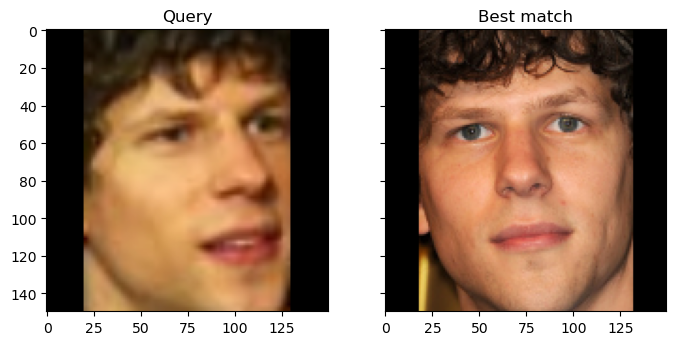

In [167]:
pca1 = PCAFeatureExtractor(5, train_X)
#THIqueryS IS A TEST FOR THE PCA
weights = pca1.transform(train_X)
# Test on out-of-sample image of existing class
query = test_X[11]

print(query.shape)
query_weight = pca1.transform(query)
euclidean_distance = np.linalg.norm(weights - query_weight, axis=1)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (train_y[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query, cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(train_X[best_match], cmap="gray")
axes[1].set_title("Best match")
plt.show()

## choosing the right number of components

This could be done either by testing different values and choosing the one that leads to greater accuracy or by analyzing the singular values. Each singular value indicates how much information does the corresponding eigenvector contain. From the following plot we notice that after the 5th vector the ammount of information start to decrease less rapidly so a good number of components would probably be around 5. THis could be a good trade-off between number of features and accuracy.

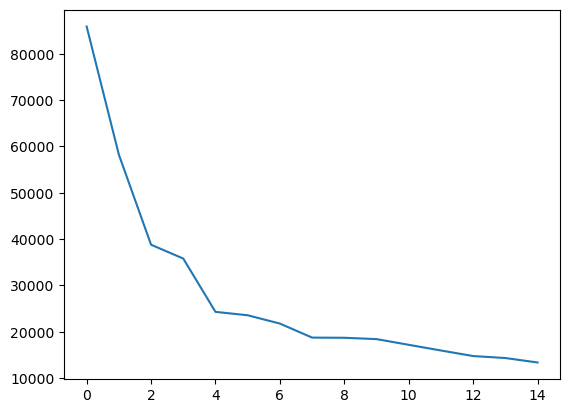

In [181]:
#plotting first 15 singular values
plt.plot(range(15), pca1.singular[:15])

### 1.2.1. Eigenface Plots
...

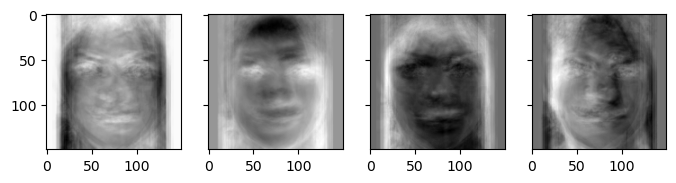

In [169]:
fig, axes = plt.subplots(1,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(4):
    axes[i].imshow(pca1.eigenfaces[i].real.reshape((150,150)), cmap="gray")
plt.show()

In [ ]:
# # WORK IN PROGRESS

# values = [2, 5, 15, 30, 80]
# plotPCA = [PCAFeatureExtractor(i, train_X) for i in values]
# query = test_X[8]
# fig, axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(9,6))
# axes[0][0].imshow(query), cmap="gray")
# axes[0][0].set_title("Original face")
# features = [plotPCA[i].transform(query) for i in range(5)]
# inverse = [plotPCA[i].inverse_transform(features[i]) for i in range(5)]
# axes[0][1].imshow(inverse[0].reshape((100,100)), cmap="gray")
# axes[0][1].set_title("using 2 eigenfaces")
# axes[0][2].imshow(inverse[1].reshape((100,100)), cmap="gray")
# axes[0][2].set_title("using 5 eigenfaces")
# axes[1][0].imshow(inverse[2].reshape((100,100)), cmap="gray")
# axes[1][0].set_title("using 15 eigenfaces")
# axes[1][1].imshow(inverse[3].reshape((100,100)), cmap="gray")
# axes[1][1].set_title("using 30 eigenfaces")
# axes[1][2].imshow(inverse[4].reshape((100,100)), cmap="gray")
# axes[1][2].set_title("using 80 eigenfaces")

### 1.2.2. Feature Space Plots
...

### 1.2.3. Discussion
...

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [20]:
from sklearn.metrics import accuracy_score

# 3. Classifiers

Now that we have created two different feature extraction models, its time to put these to the test! Below, we will create ***NUMBER OF CLASSIFIERS*** models to classify the images. We have tried multiple different models, for each type of classifier, and these will be mentioned in their respective sections. 

## 3.1 Support Vector Machine

In [109]:
class SVM:

    def __init__(self, ensemble=False):

        if not ensemble:
            self.model = svm.SVC(probability=True, kernel="rbf")
        
        else:
            models = list()
            models.append(('svm0', svm.SVC(probability=True, kernel="rbf")))
            models.append(('svm1', svm.SVC(probability=True, kernel='poly', degree=2)))
            models.append(('svm2', svm.SVC(probability=True, kernel='poly', degree=3)))
            models.append(('svm3', svm.SVC(probability=True, kernel='linear')))
            models.append(('svm4', svm.SVC(probability=True, kernel='poly', degree=4)))
            models.append(('svm5', svm.NuSVC(probability=True, nu=0.7, kernel='rbf')))
            models.append(('svm6', svm.NuSVC(probability=True, nu=0.5, kernel='rbf')))
            self.model = sklearn.ensemble.VotingClassifier(estimators=models, voting='soft')

    def fit(self, X, y):
        
        
        
        return self.model.fit(X, y) 
        
    def predict(self, X, probs=False):

        
        return self.model.predict_proba(X) if probs else self.model.predict(X)
    
    def __call__(self, X, probs=False):
        return self.predict(X, probs)

## 3.2. Deep Learning

Although we have very small amount of samples at hand, we wanted to try some deep learning solutions. Deep learning is known for its black-box nature, and its robustness generally depends on the amount of data that is fed into the model. There are some methods to counteract the lack of data at hand, which we utilize. One of the caveats (and also possibly advantages) is the immensly big solution space that it has. This is a caveat in our case, since finding the right hyperparameters takes many training iterations, many different models etc. There are some helpful API that help in solving this issue (KerasTuner from Keras, GridSearchCV from sklearn), which we have tried but in the end found to be inefficient (intuition is also a viable option). Below, more of these will be mentioned in depth.

### 3.2.1 Model Creation

#### 3.2.1.1 Compact DL Model

In [ ]:
def create_compact_model(num_classes, input_shape):
    
    inputs = keras.Input(shape=input_shape)
    x = layers.LayerNormalization(axis=-1)(inputs)
    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
#     x = layers.Dense(64, activation="relu")(x)
#     x = layers.Dropout(0.1)(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    
    outputs =layers.Dense(units, activation=activation)(x)
    
    
    return {"model": keras.Model(inputs, outputs), 
            "num_classes": num_classes, 
            "input_shape": input_shape}

#### 3.2.1.2 Transfer Learning (with an option to fine-tune) using Xception

Below, we create our second model. With such a small dataset, trying transfer learning was a no-brainer.

In [80]:
# TRANSFER LEARNING - Xception, VGG16


def create_transfer_learning_model(num_classes, input_shape, fine_tune=False, augment_data=False):

    base_model = keras.applications.Xception(
    weights='imagenet',  
    input_shape=input_shape,
    include_top=False)

    base_model.trainable = fine_tune
    
    
    inputs = keras.Input(shape=input_shape)

    if augment_data:
        
        x = layers.RandomContrast(0.2)(inputs)
        x = layers.GaussianNoise(0.2)(x)
        
    else:
        x = inputs
        
    
    x = keras.applications.xception.preprocess_input(x)
    x = base_model(x, training=fine_tune)
    x = layers.GlobalAveragePooling2D()(x)
    
    if not fine_tune:
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    
    outputs =layers.Dense(units, activation=activation)(x)
    
    
    return {"model": keras.Model(inputs, outputs), 
            "num_classes": num_classes, 
            "input_shape": input_shape}

### 3.2.2 Framework, Data Augmentation, Optimizers

In [97]:
class CustomGenerator(keras.utils.Sequence):
    
    def __init__(self, iterable, fe):
        self.iterable = iterable
        self.fe = fe
        
    def __len__(self):
        return len(self.iterable)

    def __getitem__(self, idx):
        x, y = next(self.iterable)
        return self.fe(x), y
    


class DeepLearningModel:
    
    def __init__(self, model, num_classes, input_shape, feature_extractor=None):
        
        self.model = model
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.feature_extractor = feature_extractor
    
    def fit(self, X, y, epoch=10, lr=1e-3, batch_size=4, augment_data=False, opt="adam", val_ds=None):
        
        y_OHE = keras.utils.to_categorical(y, num_classes = self.num_classes)
        
        kwargs = {}
        
        if augment_data:
            
            datagen = keras.preprocessing.image.ImageDataGenerator(
#                 featurewise_center=True,
#                 featurewise_std_normalization=True,
                rotation_range=20,
                width_shift_range=0.05,
                height_shift_range=0.05,
                shear_range=0.05,
                zoom_range=0.05,
                horizontal_flip=True,
                brightness_range=[0.9, 1.1],
                fill_mode='nearest')
            
            iterable = datagen.flow(x=X, y=y_OHE, batch_size=batch_size, shuffle=True)            

                
            
            kwargs = {"x": iterable if self.feature_extractor is None else CustomGenerator(iterable, self.feature_extractor)}
                
            
        else:
            kwargs = {"x": X if self.feature_extractor is None else self.feature_extractor(X), "y": y_OHE, "batch_size": batch_size, "shuffle":True}
    
        
        if opt == "adam":
            optimizer=keras.optimizers.Adam(lr=lr)
            
        if opt == "sgd":
            optimizer=keras.optimizers.SGD(lr=lr, momentum = 0.9)
            
        if opt == "adamw":
            optimizer = keras.optimizers.experimental.AdamW(learning_rate=lr, weight_decay=5e-3)

        self.model.compile( optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
        
          #keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
#         callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=3)]
                
    
        return self.model.fit(
                **kwargs,
            epochs=epoch,
#             callbacks=callbacks,
            validation_data=val_ds,
        )
    
        
    def predict(self, X, probs=False):
        
        if self.feature_extractor is None:
            pred = self.model.predict(X)
        else:
            feats = self.feature_extractor(X)
            pred = self.model.predict(feats)
            
        return pred if probs else np.argmax(pred, axis=-1)
    

    def __call__(self, X, probs=False):
        return self.predict(X, probs)

## 3.3 Random Forest

In [125]:
class RandomForest:
    
    def __init__(self, n_estimators=100, max_depth=2):

        self.model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)

    
    def fit(self, X, y):
        
        return self.model.fit(X, y)
        
    def predict(self, X):

        
        return self.model.predict(X)
    
    def __call__(self, X):
        return self.predict(X)

## 3.4 Ensemble Model

In [126]:
class EnsembleModel:
    
    def __init__(self, trained_models, weights):

        self.models = trained_models
        self.weights = weights
        
    def predict(self, X):
        
        preds = None
        
        for m, w in zip(self.models, self.weights):
            
            if preds is None:
                preds = w * m(X, True)
                
        
            else:
                preds += w * m(X, True)

        
        return np.argmax(preds, axis=-1)
    
    def __call__(self, X):
        return self.predict(X)

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.1 Experiments with SVM

In [110]:
### USING SVM w/ PCA

k = 20

aX, ay = train_X, train_y

feature_extractor = PCAFeatureExtractor(k, train_X)
classifier = SVM(False)

val_ds = (feature_extractor(val_X), val_y)


classifier.fit(feature_extractor(aX), ay)

svm_pipeline = lambda X, p=False: classifier(feature_extractor(X), p)

## 4.2 Experiements with Deep Learning Models

In [58]:
### PCA - DEEP LEARNING
k = 20
feature_extractor = PCAFeatureExtractor(k, train_X)
# # classifier = RandomClassificationModel()

kwargs = create_compact_model(num_classes=3, input_shape=k) # we do [1:] to NOT consider the batch size in the model
print(kwargs["model"].summary())
classifier = DeepLearningModel(**kwargs, feature_extractor=feature_extractor)

val_ds = (feature_extractor(val_X), val_y)

# train the model on the features
classifier.fit(train_X, train_y, epoch=100, lr=3e-3, batch_size=32, augment_data=False, val_ds=val_ds, opt="sgd")

# # model/final pipeline
pca_dl_pipeline = lambda X: classifier(X)

NameError: name 'PCAFeatureExtractor' is not defined

In [112]:
### USING ONLY THE PICTURES - TRANSFER LEARNING

feature_extractor = IdentityFeatureExtractor()

kwargs = create_transfer_learning_model(num_classes=3, input_shape=train_X.shape[1:], augment_data=True) # we do [1:] to NOT consider the batch size in the model
print(kwargs["model"].summary())
classifier = DeepLearningModel(**kwargs)

val_ds = (val_X, val_y)

# train the model on the features
classifier.fit(feature_extractor(train_X), train_y, epoch=30, lr=2e-3, batch_size=32, augment_data=True, val_ds=val_ds, opt="adam")

# # model/final pipeline
tf_dl_pipeline = lambda X, p=False: classifier(feature_extractor(X), p)

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 random_contrast_25 (RandomC  (None, 150, 150, 3)      0         
 ontrast)                                                        
                                                                 
 gaussian_noise_25 (Gaussian  (None, 150, 150, 3)      0         
 Noise)                                                          
                                                                 
 tf.math.truediv_25 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_25 (TFOpLa  (None, 150, 150, 3)      0         
 mbda)                                                    

In [132]:
em = EnsembleModel([tf_dl_pipeline, svm_pipeline], weights=[0.6, 0.4])


In [133]:
print(f"The performance on the training set is {accuracy_score(np.argmax(val_ds[-1], axis=-1), em(val_X)):.2f}. This however, does not tell us much about the actual performance (generalisability).")

4/4 [==============================] - 0s 38ms/step
The performance on the training set is 0.82. This however, does not tell us much about the actual performance (generalisability).


# 5. Publishing best results

In [134]:
# evaluate performance of the model on the training set
train_y_star = em(train_X)
print(train_y_star)

print(f"The performance on the training set is {accuracy_score(train_y, train_y_star):.2f}. This however, does not tell us much about the actual performance (generalisability).")

# predict the labels for the test set 
test_y_star = tf_dl_pipeline(test_X)

submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

submission.to_csv('submission.csv')

3/3 [==============================] - 0s 40ms/step
[2 2 0 2 0 1 0 1 2 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 2 1 2 1 2 2 2 2 0 2 1 1 0
 2 2 2 2 0 0 2 0 1 2 0 1 1 2 2 1 1 1 0 2 2 0 0 1 2 1 0 2 2 1 2 1 1 1 0 1 1
 2 2 0 2 2 0]
The performance on the training set is 0.95. This however, does not tell us much about the actual performance (generalisability).
57/57 [==============================] - 2s 41ms/step


# 6. Discussion
...

In summary we contributed the following: 
* 
